# Credit Card Fraud Detection using Anomaly Detection | Part 2b (Tuning)

**Problem**: Predict whether a credit card transaction is fraudulent or not based on its details. Extract the patterns that hint towards fraud by modeling the past transactions such that all frauds are detected and false positives are minimised.

**Evaluation**: Recall, PR-AUC, f1, Precision @t will be used for fine-tuning and evaluation using available labels

**Potential Solution Framework**: Since we have enough labeled data, we are using the fully-supervised anomaly detection setting (learning data structure from labels) using below two approaches. Note: One this common though, we would be trying to learn the underlying "normal" distribution & draw threshold boundary to weed out anomalies

**-----b. "End-to-end fully-supervised"-----**
    - pass whatever (normal or anomolous or both) that available training-fold labeled data is
    - then use those models to check and validate on whatever that remaining available valid-fold data is
    - Pros/Cons:
      i. We could use gridsearchcv directly
      ii. OCSVM would not perform well on such mixed data**

**Existing intuitions on algorithms (based on performance on 2D datasets)** -
Source (https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py):
- IF and LOF are good when we have multimodal data. LOF is better when modes have different desities (local aspect of LOF)
- OCSVM is sensitive to outliers and doesn't generally perform well for OD (but good for ND when training data is uncontaminated), but depending on values of hyperparamters it could still give useful results
- EllipticEnvelope assumes Gaussian distribution and thus learns ellipse. Not good for multimodal data but robust to outliers

**Useful material and references**
- https://escholarship.org/uc/item/1f03f6hb#main
- https://www.hindawi.com/journals/complexity/2019/2686378/
- https://imada.sdu.dk/~zimek/InvitedTalks/TUVienna-2016-05-18-outlier-evaluation.pdf
- https://www.gta.ufrj.br/~alvarenga/files/CPE826/Ahmed2016-Survey.pdf
 

## 1. Importing Libraries

In [42]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; 
%matplotlib inline
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import pickle
import scipy.stats as stats

#Importing data processing and prep libraries
from sklearn.preprocessing import StandardScaler, RobustScaler   #RobustScaler robust to outliers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  #for hyperparameter tuning

#Importing machine learning algo libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Importing evaluation focussed libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, average_precision_score

#Other useful libraries
#!pip install missingno   
import missingno as missviz   #Custom library for missing value inspections
from sklearn.manifold import TSNE   #For visualising high dimensional data

## 2. Getting relevant data

In [3]:
#Importing
with open("ADS_b.pkl", "rb") as f:
    X_train, X_test, y_train, y_test, X_cols, y_cols = pickle.load(f)
    
#Basic details
print("Details of training data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_train.shape, J=sum(y_train)))
print("Details of testing data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_test.shape, J=sum(y_test)))

Details of training data - shape of predictor matrix is (227845, 30) and # ones in target series is 389
Details of testing data - shape of predictor matrix is (56962, 30) and # ones in target series is 103


## 3. Hyperparameter tuning and model selection

**3.1 Splitting data into "small" and "big" parts**
- Note: We'll train and tune using the whole data in Google colab with GPUs

In [4]:
#Splitting train and test into "small" and "big" parts to expedite training and tuning
seed=123
small_frac=0.05
X_train_big, X_train_small, y_train_big, y_train_small = train_test_split(X_train, y_train, test_size=small_frac, stratify=np.array(y_train), random_state=seed)
X_test_big, X_test_small, y_test_big, y_test_small = train_test_split(X_test, y_test, test_size=small_frac, stratify=np.array(y_test), random_state=seed)

**3.2 Creating dictionary of "intialized" models and a custom scoring function for CVs**
- Note: that we need this custom scoring function for CV steps, since output of anomaly detection model prediction is {-1,1}, so in order to use f1_score appropriately, we'll need to make this transformation in predicted values of y, else it behaves weirdly

In [79]:
#Creating a dictionary of "initialized" defualt models
models={
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM(random_state=seed)}

#Creating a custom scoring function for RSCV & GSCV (which takes in 3 arguments - model, X, y)
def my_f1_score(model, X, y):
    y_pred=model.predict(X)
    return f1_score(y, np.where(y_pred==1,0,1))

**3.3 Training and tuning models**
     1. Using RandomizedSearchCV first (also fast) to determine interesting hyperparameter space
     2. Then, we'll use GridSearchCV later to narrow down to the specifics (space where performance seems good)

**3.3.1 RandomizedSearchCV (and validation curve)**

In [82]:
#Creating a dictionary of models' hyperparameters for RSCV
model_hp_dist_rscv={
    "IF": {"contamination": stats.uniform(0.00001, 0.1) , "max_samples": stats.randint(10,1000), "n_estimators": stats.randint(2,1000),
    "LOF": {"contamination": stats.uniform(0.00001, 0.1), "n_neighbors": stats.randint(2,500)},
    "OCSVM": {"nu": stats.uniform(0.00001, 0.1), "kernel": ["linear", "rbf", "poly"], "gamma": stats.expon(scale=.1)}}}

results_rscv=[]
for model_name in models.keys():
    print("-----Running RandomizedSearchCV for {M}-----".format(M=model_name))
    model=models[model_name]
    hp=model_hp_grid_gscv[model_name]
    RSCV=RandomizedSearchCV(model, hp, cv=3, n_iter=10, random_state=seed, scoring=my_f1_score, n_jobs=-1, verbose=10)
    %time RSCV.fit(X_train_small, y_train_small)
    results_rscv.append([model_name, RSCV.best_params_, RSCV.best_score_, RSCV.cv_results_])
    
results_rscv_df=pd.DataFrame(results_rscv, columns=["model_name", "best_hp", "best_score", "CV_results"])

-----Running RandomizedSearchCV for IF-----
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   15.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   19.3s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   22.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.3s finished


CPU times: user 596 ms, sys: 159 ms, total: 755 ms
Wall time: 23.6 s
-----Running RandomizedSearchCV for LOF-----
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   52.0s remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   53.3s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.1min remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


CPU times: user 7.54 s, sys: 228 ms, total: 7.77 s
Wall time: 1min 14s
-----Running RandomizedSearchCV for OCSVM-----
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    2.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    4.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    5.1s remaining:    0.6s


CPU times: user 735 ms, sys: 41.1 ms, total: 776 ms
Wall time: 12.1 s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.9s finished


----------------------
 Validation Curves 
----------------------
< IF >


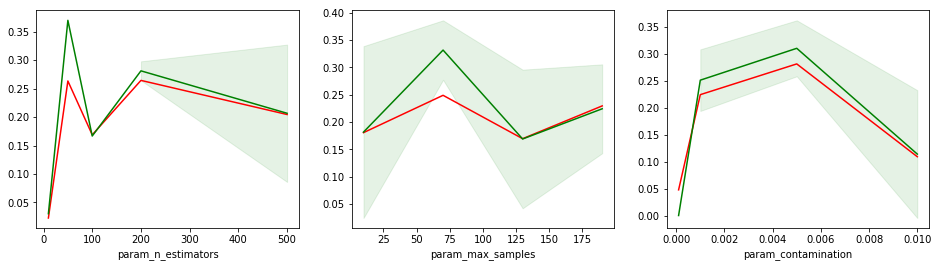

< LOF >


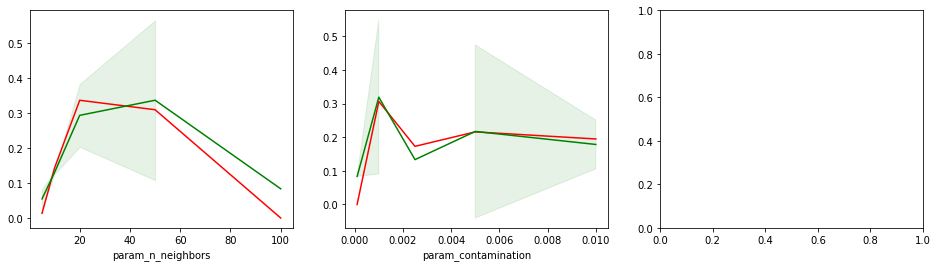

< OCSVM >


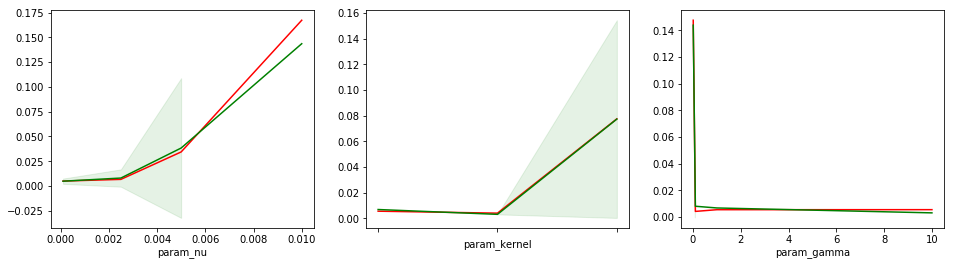

In [235]:
#Plotting validation curves:
results_model_df_dict={}
print("----------------------\n Validation Curves \n----------------------", )
for model_name in models.keys():
    print("<", model_name, ">")
    results_model_df = pd.DataFrame(results_rscv_df[results_rscv_df["model_name"]==model_name]['CV_results'].values[0])    
    hp_cols_model = [col for col in results_model_df.columns if ("param_" in col)]
    
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs=axs.flatten()
    for i, hp_col in enumerate(hp_cols_model):
        results_model_df.groupby(hp_col)["mean_train_score"].mean().plot(ax=axs[i], color='red')
        results_model_df.groupby(hp_col)["mean_test_score"].mean().plot(ax=axs[i], color='green')
        
        mean = results_model_df.groupby(hp_col)["mean_test_score"].mean()
        std = results_model_df.groupby(hp_col)["mean_test_score"].std()
        axs[i].fill_between(sorted(set(results_model_df[hp_col])), mean + std, mean - std, color = 'green', alpha = 0.1)
    plt.show()

**3.3.2 GridSearchCV**

In [70]:
model_hp_grid_gscv={
    "IF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "max_samples": list(range(10,300,60)), "n_estimators": [10,50,100,200,500]},
    "LOF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "n_neighbors": [5,10,20,50,100]},
    "OCSVM": {"nu": [0.0001, 0.001, 0.0025, 0.005, 0.01], "kernel": ["linear", "rbf", "poly"], "gamma": np.power(10.0, range(-3,2))}}

